In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
import os 
os.chdir("D:/Downloads/Brainwaves/1")
#os.listdir()

In [2]:
Train=pd.read_csv("converted_data_train.csv")
Test=pd.read_csv("converted_data_test.csv")

In [3]:
Train.head()

,Complaint-ID,Date-received,Transaction-Type,Complaint-reason,Company-response,Date-sent-to-company,Complaint-Status,Consumer-disputes,Consumer-complaint-summary,converted_text,convertion_language
0,Tr-1,11/11/2015,Mortgage,"Loan servicing, payments, escrow account",NaN,11/11/2015,Closed with explanation,Yes,"Seterus, Inc a déposé un faux rapport auprès d...","Seterus, Inc. filed a false report with the ma...",fr
1,Tr-2,7/7/2015,Credit reporting,Incorrect information on credit report,Company chooses not to provide a public response,7/7/2015,Closed with non-monetary relief,No,XX / XX / XXXX La requête en faillite n ° XXXX...,XX / XX / XXXX Bankruptcy Claim XXXX of Chapte...,fr
2,Tr-3,5/7/2015,Bank account or service,Using a debit or ATM card,NaN,5/7/2015,Closed with explanation,No,"El XXXX / XXXX / 15, estaba preparando el vuel...","XXXX / XXXX / 15, I was preparing the flight b...",es
3,Tr-4,11/12/2016,Debt collection,Cont'd attempts collect debt not owed,Company believes it acted appropriately as aut...,11/12/2016,Closed with explanation,No,"The loan was paid in XXXX XXXX. In XXXX, 4 yea...","The loan was paid in XXXX XXXX. In XXXX, 4 yea...",en
4,Tr-5,9/29/2016,Credit card,Payoff process,Company has responded to the consumer and the ...,9/29/2016,Closed with explanation,No,J'ai obtenu un compte de crédit de soins pour ...,I got a care credit account for XXXX. Immediat...,fr


In [4]:
df=Train.append(Test)
df=Train.copy()

In [5]:
df=df[['Complaint-Status','converted_text']]
df.fillna('Missing',inplace=True)

In [6]:
df['Complaint_id'] = df['Complaint-Status'].factorize()[0]
from io import StringIO
category_id_df = df[['Complaint-Status', 'Complaint_id']].drop_duplicates().sort_values('Complaint_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Complaint_id', 'Complaint-Status']].values)

In [7]:
df['Complaint-Status'].value_counts()

Closed with explanation            34300
Closed with non-monetary relief     5018
Closed with monetary relief         2818
Closed                               809
Untimely response                    321
Name: Complaint-Status, dtype: int64

In [8]:
df.head()

,Complaint-Status,converted_text,Complaint_id
0,Closed with explanation,"Seterus, Inc. filed a false report with the ma...",0
1,Closed with non-monetary relief,XX / XX / XXXX Bankruptcy Claim XXXX of Chapte...,1
2,Closed with explanation,"XXXX / XXXX / 15, I was preparing the flight b...",0
3,Closed with explanation,"The loan was paid in XXXX XXXX. In XXXX, 4 yea...",0
4,Closed with explanation,I got a care credit account for XXXX. Immediat...,0


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(df.converted_text)
labels = df.Complaint_id
features.shape

(43266, 1068446)

In [10]:
df['Complaint_id'].value_counts()

0    34300
1     5018
3     2818
2      809
4      321
Name: Complaint_id, dtype: int64

In [11]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Closed':
  . Most correlated unigrams:
       . fortiva
       . scottrade
  . Most correlated bigrams:
       . scottrade xxxx
       . scottrade bank
# 'Closed with explanation':
  . Most correlated unigrams:
       . card
       . experian
  . Most correlated bigrams:
       . rush card
       . enhanced recovery
# 'Closed with monetary relief':
  . Most correlated unigrams:
       . fee
       . overdraft
  . Most correlated bigrams:
       . overdraft fee
       . 35 00
# 'Closed with non-monetary relief':
  . Most correlated unigrams:
       . midland
       . experian
  . Most correlated bigrams:
       . experian credit
       . enhanced recovery
# 'Untimely response':
  . Most correlated unigrams:
       . lhr
       . mobiloans
  . Most correlated bigrams:
       . telling court
       . richard sokoloff


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

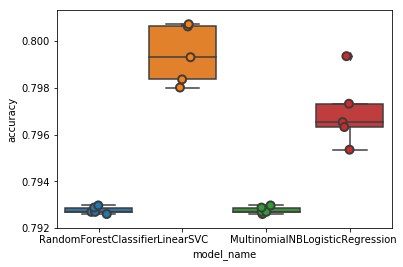

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.799404
LogisticRegression        0.796977
MultinomialNB             0.792770
RandomForestClassifier    0.792770
Name: accuracy, dtype: float64

In [15]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

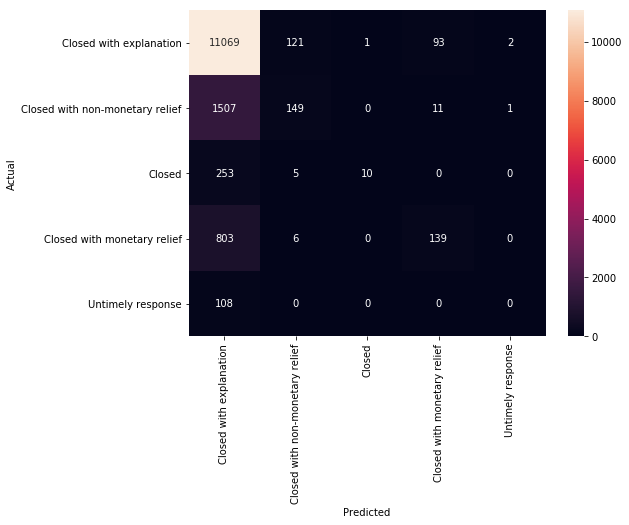

In [16]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['Complaint-Status'].values, yticklabels=category_id_df['Complaint-Status'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Complaint-Status'].unique()))

                                 precision    recall  f1-score   support

        Closed with explanation       0.81      0.98      0.88     11286
Closed with non-monetary relief       0.53      0.09      0.15      1668
                         Closed       0.91      0.04      0.07       268
    Closed with monetary relief       0.57      0.15      0.23       948
              Untimely response       0.00      0.00      0.00       108

                      micro avg       0.80      0.80      0.80     14278
                      macro avg       0.56      0.25      0.27     14278
                   weighted avg       0.75      0.80      0.73     14278



In [18]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,average='weighted')

0.7339348823133791

In [19]:
Test.fillna('Missing',inplace=True)
test_features = tfidf.transform(Test['converted_text'])

In [20]:
model.fit(features,labels)
predictions = model.predict(test_features)

In [21]:
Test=pd.read_csv('converted_data_test.csv')
Test=Test[['Complaint-ID','converted_text']]
Test['Complaint-Status']=predictions
num_map = {0:'Closed with explanation', 1:'Closed with non-monetary relief',2:'Closed',3:'Closed with monetary relief'\
          ,4:'Untimely Response'}

Test['Complaint-Status'] = Test['Complaint-Status'].map(num_map)

In [22]:
Test=Test[['Complaint-ID','Complaint-Status']]

In [23]:
features

<43266x1068446 sparse matrix of type '<class 'numpy.float64'>'
	with 5522920 stored elements in Compressed Sparse Row format>

In [25]:
Train=pd.read_csv("converted_data_train.csv")

#Over-sampling the dataset by doubling the lower classes 

df=Train.copy()
df1=df[df['Complaint-Status']=='Closed with explanation'].reset_index(drop=True)
df2=df[df['Complaint-Status']!='Closed with explanation'].reset_index(drop=True)
df3=df[df['Complaint-Status']=='Untimely Response'].reset_index(drop=True)
df4=df[df['Complaint-Status']=='Closed'].reset_index(drop=True)

df=pd.concat([df1,df2,df2],axis=0)
df.reset_index(inplace=True,drop=True)

Train=df.copy()
Train['converted_text'].fillna('Missing',inplace=True)

features = tfidf.fit_transform(Train.converted_text)

Test=pd.read_csv("converted_data_test.csv")
Test['converted_text'].fillna('Missing',inplace=True)

features_test = tfidf.transform(Test.converted_text)

labels=Train['Complaint-Status']

Train.drop(['Complaint-Status'],axis=1,inplace=True)

all_data=Train.append(Test)
all_data.head(1)

,Complaint-ID,Date-received,Transaction-Type,Complaint-reason,Company-response,Date-sent-to-company,Consumer-disputes,Consumer-complaint-summary,converted_text,convertion_language
0,Tr-1,11/11/2015,Mortgage,"Loan servicing, payments, escrow account",NaN,11/11/2015,Yes,"Seterus, Inc a déposé un faux rapport auprès d...","Seterus, Inc. filed a false report with the ma...",fr


In [26]:
all_data['Date-received']=pd.to_datetime(all_data['Date-received'])
all_data['Date-sent-to-company']=pd.to_datetime(all_data['Date-sent-to-company'])
all_data['diff_days']=(all_data['Date-sent-to-company']-all_data['Date-received']).dt.days
all_data['day_of_week'] = all_data['Date-received'].dt.day_name()
all_data['recd_month']=all_data['Date-received'].dt.month

import string

all_data['consumer_summary_n_words']=all_data['Consumer-complaint-summary'].str.count(' ') + 1
all_data["mean_word_len"] = all_data["Consumer-complaint-summary"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
all_data["num_unique_words"] = all_data["Consumer-complaint-summary"].apply(lambda x: len(set(str(x).split())))
all_data["num_chars"] = all_data["Consumer-complaint-summary"].apply(lambda x: len(str(x)))
all_data["num_punctuations"] =all_data['Consumer-complaint-summary'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
all_data["num_words_upper"] = all_data["Consumer-complaint-summary"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
all_data["num_words_title"] = all_data["Consumer-complaint-summary"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
all_data.drop(['converted_text','Consumer-complaint-summary','Complaint-ID','convertion_language'],axis=1,inplace=True)

In [27]:
all_data.drop(["Date-received","Date-sent-to-company"],axis=1,inplace=True)
num_map = {'Monday':1, 'Tuesday':2,'Wednesday':3,'Thursday':4\
          ,'Friday':5,'Saturday':6,'Sunday': 7}

all_data['day_of_week'] = all_data['day_of_week'].map(num_map)

In [28]:
all_data["Company-response"]=all_data["Company-response"].fillna("Extras")
all_data["Consumer-disputes"]=all_data["Consumer-disputes"].fillna("Unknown")

In [29]:
from sklearn.preprocessing import LabelEncoder
le1=LabelEncoder()
cat_var=["Transaction-Type","Complaint-reason","Company-response","Consumer-disputes"]
for vr in cat_var:
    all_data[vr]=le1.fit_transform(all_data[vr])

In [30]:
all_data.head(1)

,Transaction-Type,Complaint-reason,Company-response,Consumer-disputes,diff_days,day_of_week,recd_month,consumer_summary_n_words,mean_word_len,num_unique_words,num_chars,num_punctuations,num_words_upper,num_words_title
0,10,79,10,2,0,3,11,77,4.896104,62,453,7,5,4


In [31]:
X_train=all_data[:Train.shape[0]]
X_test=all_data[Train.shape[0]:]

In [32]:
print(X_train.shape)
X_train.tail(1)

(52232, 14)


,Transaction-Type,Complaint-reason,Company-response,Consumer-disputes,diff_days,day_of_week,recd_month,consumer_summary_n_words,mean_word_len,num_unique_words,num_chars,num_punctuations,num_words_upper,num_words_title
52231,3,51,9,0,0,3,3,117,4.033613,82,600,19,10,11


In [33]:
print(X_test.shape)
X_test.head(1)

(18543, 14)


,Transaction-Type,Complaint-reason,Company-response,Consumer-disputes,diff_days,day_of_week,recd_month,consumer_summary_n_words,mean_word_len,num_unique_words,num_chars,num_punctuations,num_words_upper,num_words_title
0,0,1,9,0,0,4,8,212,4.419811,108,1148,27,23,20


In [34]:
from scipy.sparse import hstack, vstack, csr_matrix

In [35]:
feat_train = csr_matrix(X_train.values)
feat_test = csr_matrix(X_test.values)

In [36]:
X_train_stack = hstack([feat_train, features[0:feat_train.shape[0]]])
X_test_stack = hstack([feat_test, test_features[0:feat_test.shape[0]]])

In [37]:
print('Train shape: ', X_train_stack.shape, '\n\nTest Shape: ', X_test_stack.shape)

Train shape:  (52232, 1068460) 

Test Shape:  (18543, 1068460)


In [38]:
"""Running the model on oversampled dataset to check the model's prediction level for the lower-occurring classes.
This may not work everytime. Also assumption: ~1% greater f1-score because of the repetition of the training data in test
data, but only 1% because split is 80-20 and other classes are really low in number. Cross-validation on oversampled dataset
is not the best of practices and may lead to misleading validation scores."""

import lightgbm as lgb

model=lgb.LGBMClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_train_stack, labels, X_train.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [39]:
f1_score(y_pred,y_test,average='weighted')

0.7707613959380252

In [40]:
model.fit(X_train_stack,labels)
final_preds=model.predict(X_test_stack)

C:\Users\dutta\Anaconda3\lib\site-packages\lightgbm\basic.py:469: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [41]:
Test=pd.read_csv('converted_data_test.csv')
Test=Test[['Complaint-ID','converted_text']]
Test['Complaint-Status']=final_preds
num_map = {0:'Closed with explanation', 1:'Closed with non-monetary relief',2:'Closed',3:'Closed with monetary relief'\
          ,4:'Untimely Response'}

Test['Complaint-Status'] = Test['Complaint-Status'].map(num_map)

In [42]:
Test.drop(['converted_text'],axis=1,inplace=True)

In [43]:
Test['Complaint-Status'].value_counts()

Series([], Name: Complaint-Status, dtype: int64)

In [44]:
Test.to_csv('submission_file_lgb.csv',index=False)